In [17]:
import torch
import numpy as np
from aihwkit.nn import AnalogLinear
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit_test.customized_noise_pcm import TestNoiseModel  # 사용자 정의 noise model
from network import InfModel

# 테스트할 g_min, g_max 조합
g_minmax_list = [[0, 25], [1, 25], [5, 25], [10, 25]]

# 간단한 네트워크 (1-layer) 생성
model = torch.nn.Linear(10,10, bias=True)  # 10x10 weight matrix

for g_list in g_minmax_list:
    g_min, g_max = g_list
    print(f"\n=== Testing with g_min={g_min}, g_max={g_max} ===")

    # Inference Model 설정
    inf_model = InfModel(model=model, mode="cifar10", g_list=[g_min, g_max])
    analog_model = inf_model.ConvertModel()
    rpu_config = inf_model.SetConfig()
    
    # print("\n=== Analog Model Named Parameters ===")
    # for name, param in analog_model.named_parameters():
    #     print(f"name: {name}, shape: {param.shape}")

    # Conductance 변환
    for name, param in analog_model.named_parameters():
        if "analog_module.shared_weights" in name:
            weights = param.data.cpu()
            
            # Convert to conductance
            conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
            gp, gm = conductance_pair[0]  # (Gp, Gm)
            # print(f'gp: {gp}')
            # print(f'gm: {gm}')

            # `g_target` 값 설정 (다양한 conductance 값 테스트)
            g_target_values = [gp.min().item(), (gp.min().item() + gp.max().item()) / 2, gp.max().item()]

            for g_target in g_target_values:
                drift_coeff = rpu_config.noise_model.generate_drift_coefficients(torch.tensor([g_target]))
                
                print(f"g_target={g_target:.6f} → Drift Coeff: {drift_coeff.item():.6f}")




=== Testing with g_min=0, g_max=25 ===
g_target=0.000000 → Drift Coeff: 0.274230
g_target=12.500000 → Drift Coeff: 0.035144
g_target=25.000000 → Drift Coeff: 0.024400

=== Testing with g_min=1, g_max=25 ===
g_target=1.000000 → Drift Coeff: 0.074293
g_target=13.000000 → Drift Coeff: 0.034536
g_target=25.000000 → Drift Coeff: 0.024400

=== Testing with g_min=5, g_max=25 ===
g_target=5.000000 → Drift Coeff: 0.049346
g_target=15.000000 → Drift Coeff: 0.032318
g_target=25.000000 → Drift Coeff: 0.024400

=== Testing with g_min=10, g_max=25 ===
g_target=10.000000 → Drift Coeff: 0.038603
g_target=17.500000 → Drift Coeff: 0.029928
g_target=25.000000 → Drift Coeff: 0.024400


In [10]:
name, param = analog_model.named_parameters()

In [16]:
type(param[1])

torch.nn.parameter.Parameter

In [17]:
weights = param[1].data.cpu()

In [18]:
weights

tensor([ 0.1707, -0.2422,  0.1681,  0.0057,  0.2799,  0.2481,  0.1535,  0.0952,
         0.0088, -0.2817])

In [12]:
model = torch.nn.Linear(10,10, bias=True)
for name, param in model.named_parameters():
        print(f"name: {name}, shape: {param.shape}")

name: weight, shape: torch.Size([10, 10])
name: bias, shape: torch.Size([10])


In [1]:
from Model.PyTorch_CIFAR10.cifar10_models.resnet import resnet18
model = resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
from Model.PyTorch_CIFAR10.cifar10_models.vgg import vgg16_bn

In [21]:
model = vgg16_bn(pretrained=True)

In [24]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [25]:
from Model.PyTorch_CIFAR10.cifar10_models.resnet import resnet18
model2 = resnet18(pretrained=True)

In [26]:
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

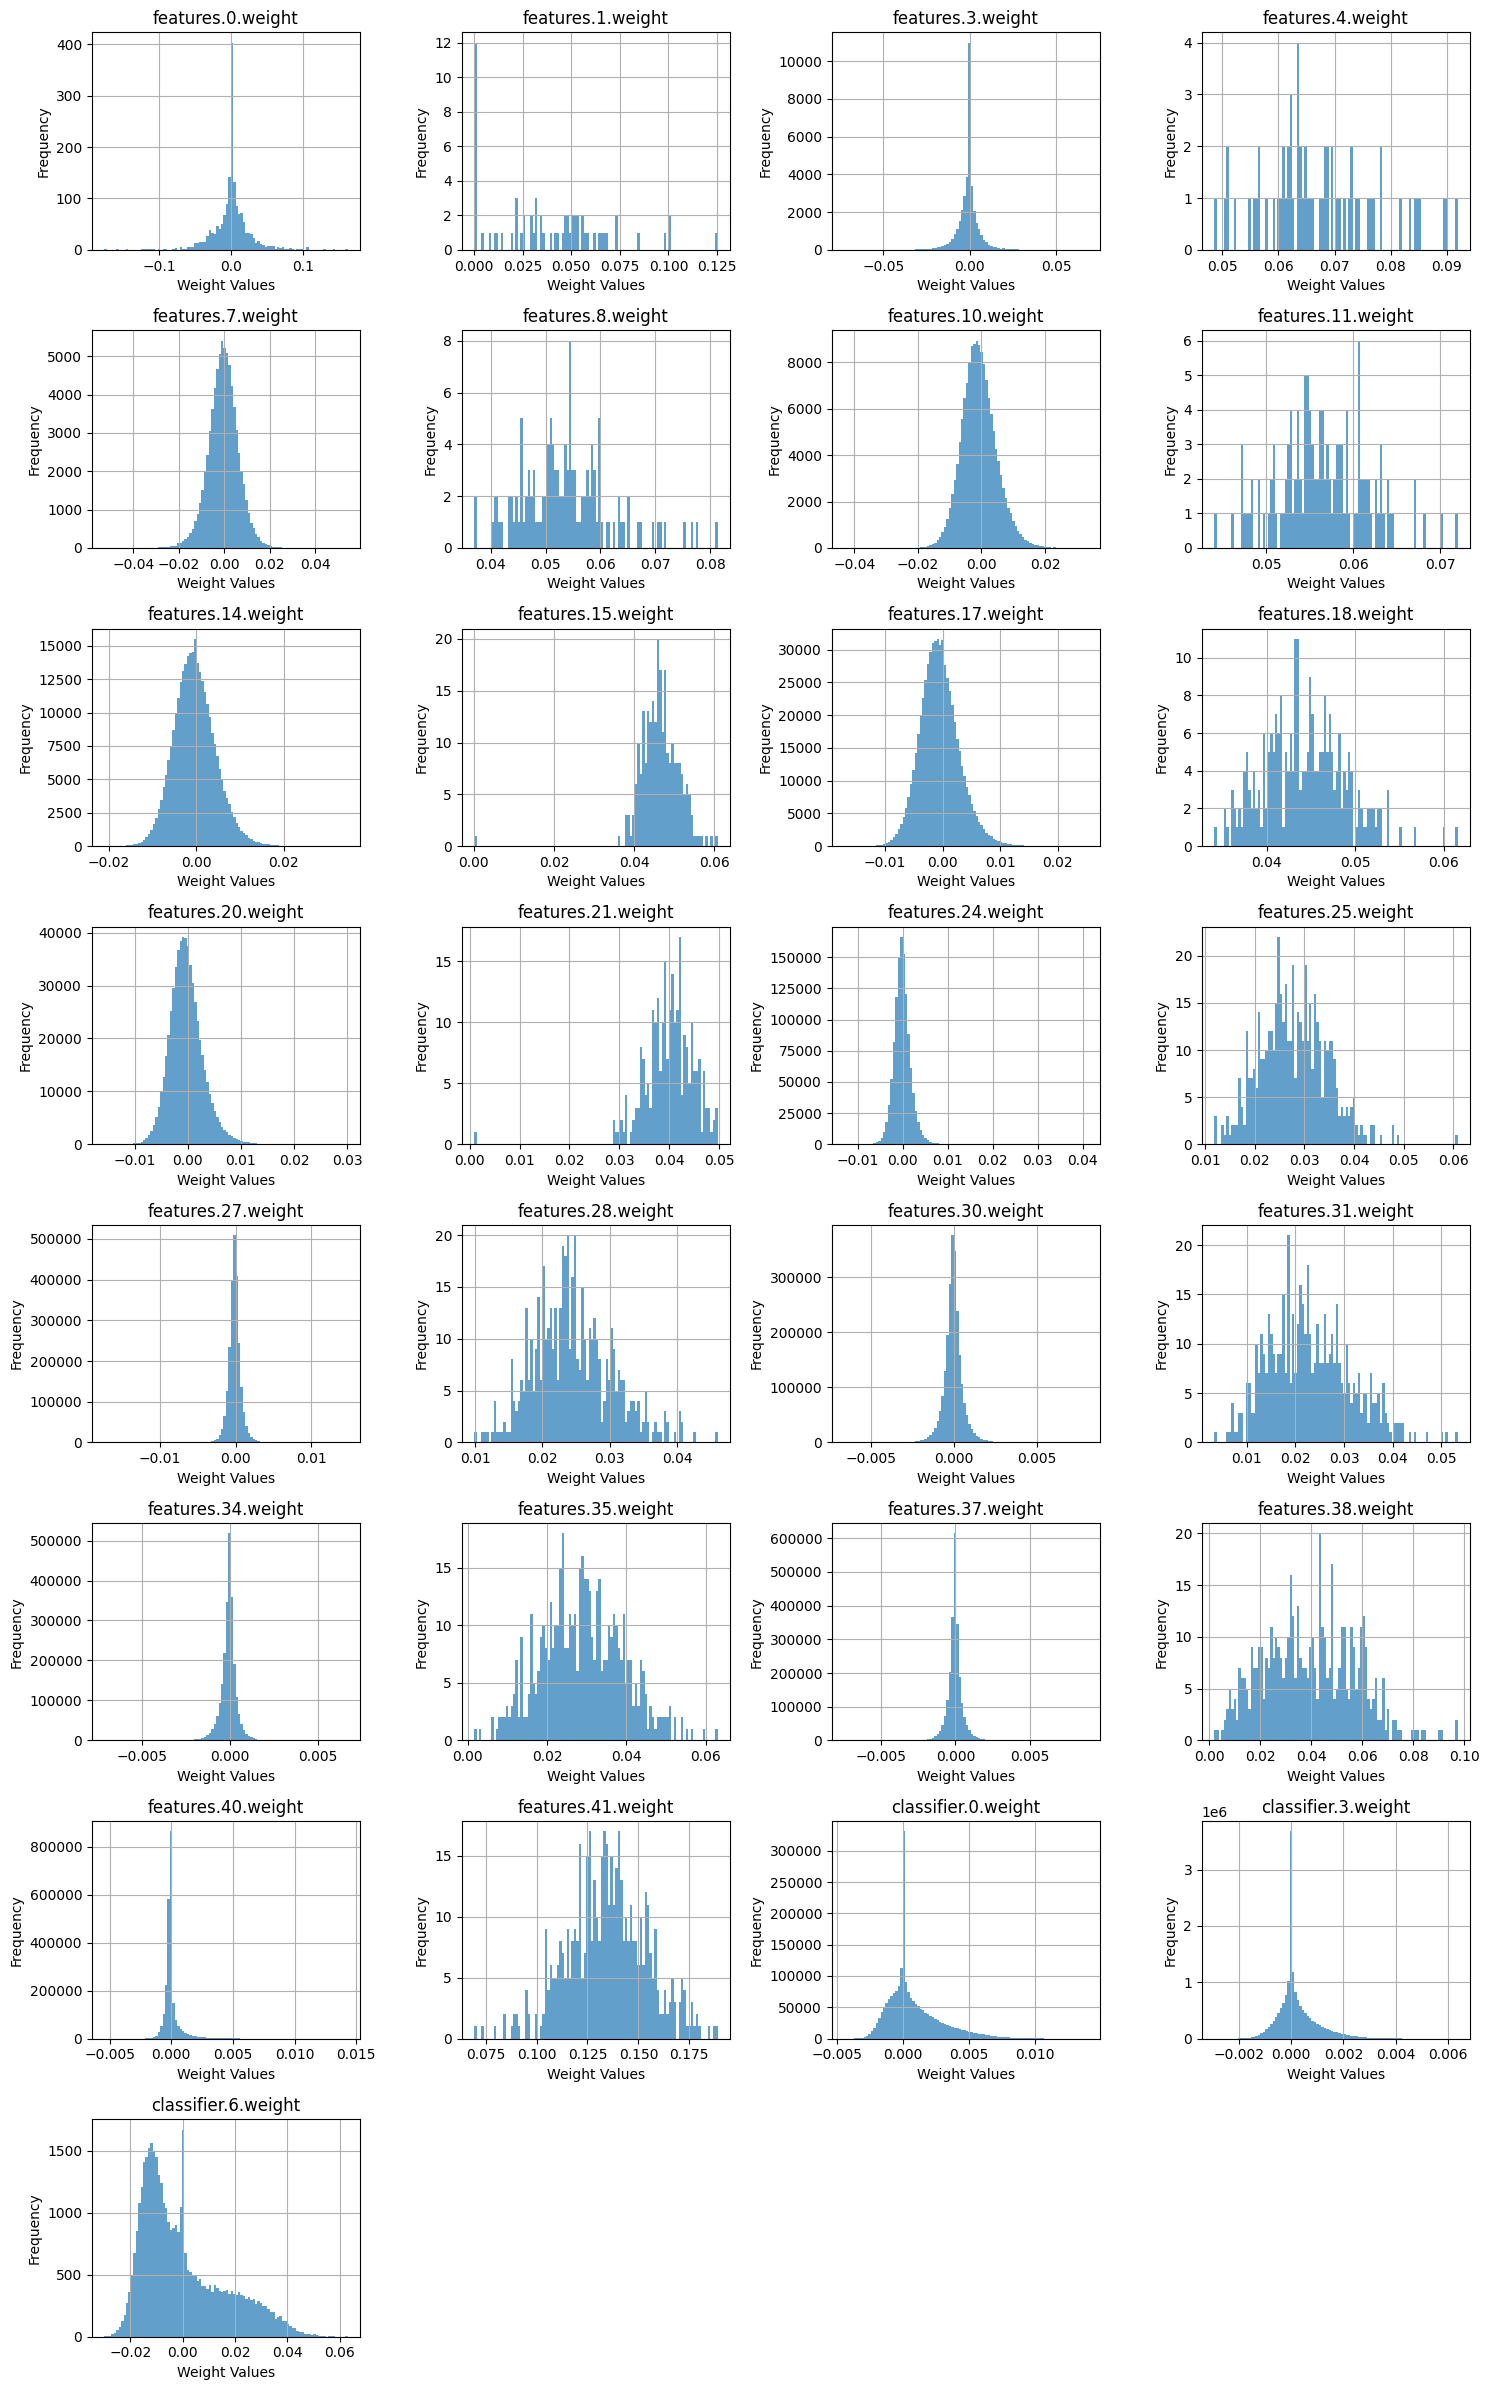

In [27]:
import torch
from Model.PyTorch_CIFAR10.cifar10_models.vgg import vgg16_bn
import matplotlib.pyplot as plt
import numpy as np

# 1. VGG16 모델 (BatchNorm 포함) 불러오기
model = vgg16_bn(pretrained=True)

# 2. 레이어별 weight 가져오기
weights = {name: param.detach().cpu().numpy().flatten() 
           for name, param in model.named_parameters() if 'weight' in name}

# 3. Subplot 설정
num_layers = len(weights)
cols = 4  # 한 줄에 표시할 subplot 개수
rows = (num_layers + cols - 1) // cols  # 필요한 행 수 계산

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()  # 1D 배열로 변환하여 인덱싱 가능하게 만들기

# 4. 각 레이어별 weight 분포 그리기
for idx, (name, w) in enumerate(weights.items()):
    axes[idx].hist(w, bins=100, alpha=0.7)
    axes[idx].set_title(f"{name}")  # 레이어 이름 추가
    axes[idx].set_xlabel("Weight Values")
    axes[idx].set_ylabel("Frequency")
    axes[idx].grid(True)

# 나머지 빈 subplot 숨기기
for idx in range(num_layers, len(axes)):
    axes[idx].axis('off')

# 5. 그래프 표시
plt.tight_layout()
plt.show()


In [29]:
import numpy as np

np.log(2)

0.6931471805599453

In [ ]:
import torch
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as dsets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar10_transform_train = transforms.Compose([
                                transforms.RandomCrop(32, padding=4),  # for data augmentation
                                transforms.RandomHorizontalFlip(),     # for data augmentation
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))
        ])

# cifar10 dataset
cifar10_train = dsets.CIFAR10(root='dataset/',
                        train=True,
                        download=True,
                        transform=cifar10_transform_train)



for num_workers in [0, 1, 2, 4, 8]:
    trainloader = DataLoader(cifar10_train, batch_size=128, shuffle=True, num_workers=num_workers)
    
    start = time.time()
    for batch in trainloader:
        batch = batch[0].to(device)  # GPU로 데이터 이동 (실제 연산 포함)
    end = time.time()
    
    print(f'num_workers={num_workers}: {end - start:.2f} sec')


Files already downloaded and verified
num_workers=0: 6.21 sec
num_workers=1: 7.41 sec
num_workers=2: 4.72 sec
num_workers=4: 2.45 sec
num_workers=8: 1.74 sec


In [3]:
import torch
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as dsets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar10_transform_train = transforms.Compose([
                                transforms.RandomCrop(32, padding=4),  # for data augmentation
                                transforms.RandomHorizontalFlip(),     # for data augmentation
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))
        ])

# cifar10 dataset
cifar10_train = dsets.CIFAR10(root='dataset/',
                        train=True,
                        download=True,
                        transform=cifar10_transform_train)



for num_workers in [0, 1, 2, 4, 8]:
    trainloader = DataLoader(cifar10_train, batch_size=128, shuffle=True, num_workers=num_workers)
    
    start = time.time()
    for batch in trainloader:
        batch = batch[0].to(device)  # GPU로 데이터 이동 (실제 연산 포함)
    end = time.time()
    
    print(f'num_workers={num_workers}: {end - start:.2f} sec')

Files already downloaded and verified
num_workers=0: 10.01 sec
num_workers=1: 7.42 sec
num_workers=2: 4.33 sec
num_workers=4: 2.44 sec
num_workers=8: 1.79 sec
